In [1]:
from scipy.ndimage import gaussian_filter, sobel, median_filter, convolve
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage.color import rgb2yuv


In [16]:
GREY = True
YUV = not GREY and False

def rgb2grey(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def read(path):
    img = plt.imread(path)
    if GREY:
        img = rgb2grey(img)
        
    if YUV:
        img = rgb2yuv(img)
    return img

def color_convolve(im1, im2):
    r = convolve2d(im1[:,:,0], im2, 'same')
    g = convolve2d(im1[:,:,1], im2, 'same')
    b = convolve2d(im1[:,:,2], im2, 'same')
    return np.dstack((r,g,b))

def binarize(img, quantile=0.9, alpha=0.9):
    thres = np.quantile(img, quantile) * alpha
    result = img.copy()
    result[result < thres] = 0
    result[result > 0] = 1
    return result

def get_subplot_tag(n_images, max_y = 3):
    y = min(max_y, n_images)
    x = (n_images // max_y) + 1
    return f"{x}{y}"
    
def plot_all(list_img):
    n = len(list_img)
    max_y = 3
    
    y = min(max_y, n)
    x = (n // max_y) + 1
    plt.figure(figsize=(14,8))
    
    for i, key in enumerate(list_img):
        tag = f"{x}{y}{i + 1}"
        plt.subplot(tag)
        if GREY:
            plt.imshow(list_img[key], cmap="gray")
        else:
            plt.imshow(list_img[key])
        plt.title(key)

img_j   = read('by_class/J/hsf_0/hsf_0_00000.png')
license_plate   = read('license_plate.jpg')
tintin   = read('tintin.jpg')
text   = read('text.png')
img_stop = read('stop.png')
flower = read('flower.jpg')


print(img_j.shape)

(128, 128)


In [9]:
# for canny edge detection

from scipy.ndimage import gaussian_filter
from scipy import ndimage

def gaussian_smoothing(img):
    return gaussian_filter(img[:,:],sigma=1)

def gradient(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    magnitude = np.hypot(Ix, Iy)
    magnitude = magnitude / magnitude.max() * 255
    direction = np.arctan2(Iy, Ix)
    return (magnitude, direction)

def non_maximum_suppression(magnitude, Direction):
    H, W = magnitude.shape
    Z = np.zeros((H,W), dtype=np.int32)
    angle = Direction * 180. / np.pi
    angle[angle < 0] += 180 
    for i in range(1,H-1):
        for j in range(1,W-1):
            q = 255
            r = 255
            #Gradient directions :       
            #angle 
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = magnitude[i, j+1]
                r = magnitude[i, j-1]
            #angle Pi/4
            elif (22.5 <= angle[i,j] < 67.5):
                q = magnitude[i+1, j-1]
                r = magnitude[i-1, j+1]
            #angle Pi/2
            elif (67.5 <= angle[i,j] < 112.5):
                q = magnitude[i+1, j]
                r = magnitude[i-1, j]
            #angle 3Pi/4
            elif (112.5 <= angle[i,j] < 157.5):
                q = magnitude[i-1, j-1]
                r = magnitude[i+1, j+1]
            if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                Z[i,j] = magnitude[i,j]
            else:
                Z[i,j] = 0
    return Z

def double_thresholding(img, thresh_lo, thresh_hi):
    
    highThreshold = img.max() * thresh_hi;
    lowThreshold = highThreshold * thresh_lo;
    
    H, W = img.shape
    res = np.zeros((H,W), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def connectivity(img, weak, strong):
    H, W = img.shape  
    for i in range(1, H-1):
        for j in range(1, W-1):
            if (img[i,j] == weak):
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
              
    return img

def canny_edge_detector(img, thresh_lo=0.1, thresh_hi=0.2):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    smoothed             = gaussian_smoothing(img/255)
    
    # Find gradient magnitude and direction
    g_magnitude, g_dir = gradient(smoothed)
    
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    # Double thresholding
    thresh_img,weak,strong     = double_thresholding(g_max, thresh_lo, thresh_hi)

    # Final edge connectivity
    edge_img             = connectivity(thresh_img,weak,strong)
    
    # Return the result
    return edge_img

# img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# edges = canny_edge_detector(img,0.3,0.3)

(128, 128)


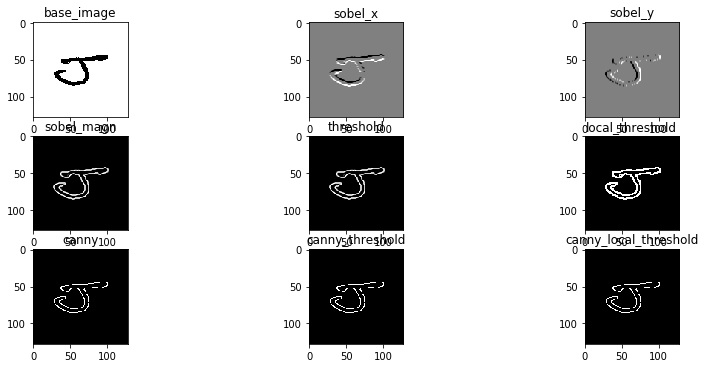

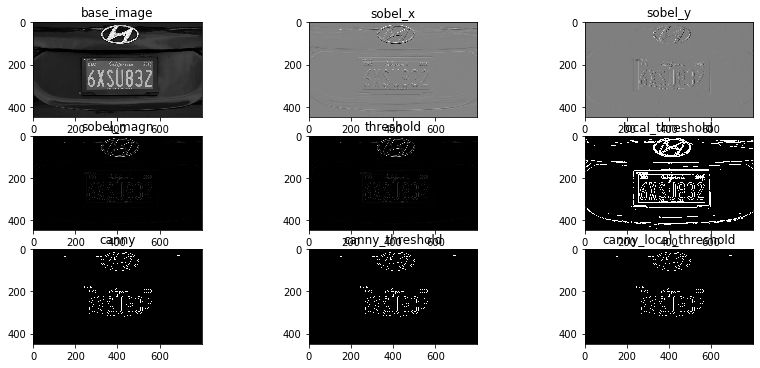

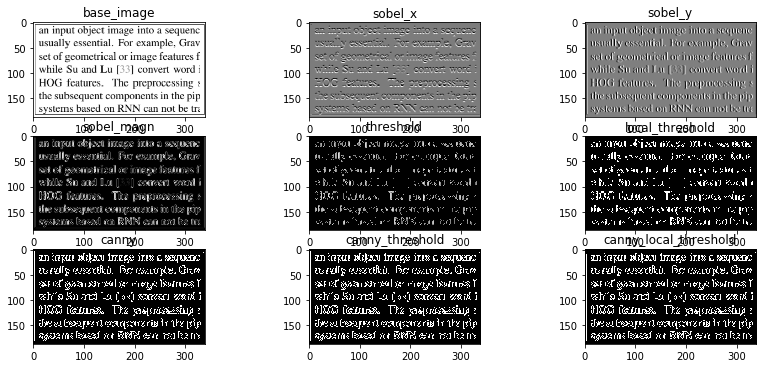

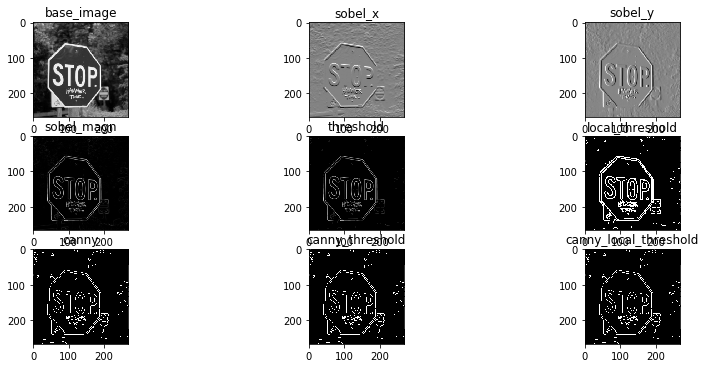

In [68]:
def low_threshold(img, quantile = 0.9, alpha = 0.9):
    # the idea behind this thresholding is that, we expect edges of text to have higher values that edges of background
    # so we take a threshold relative close to edges of text
    
    if len(img.shape) == 3: # color img, but should never be the case
        result = img.copy()
        for i in range(3):
            thres = np.quantile(img[:,:,i], quantile) * alpha
            dummy = result[:,:,i]
            dummy[dummy < thres] = 0
            result[:,:,i] = dummy
    else:   
        thres = np.quantile(img, quantile) * alpha
        result = img.copy()
        result[result < thres] = 0

    return result

def local_threshold(img, H, W):
    def simple(window):
        x, y = window.shape[0:2]
        count_blank_line = 0
        for i in range(x):
            if not np.any(window[i,:]):
                count_blank_line += 1
        return count_blank_line > 0.1 * H
    
    def window_threshold_idx(window):
        thres = np.quantile(window, 0.9)
        return np.argwhere(window < thres)
    
    x, y = img.shape[0:2]
    step_x = int(H/2)
    step_y = int(W/2)
    
    marked_points = None
    
    for i in range(0, x, step_x):
        for j in range(0, y, step_y):
            window = img[i: i + H, j: j + W]
            
            if not simple(window):
                marked = window_threshold_idx(window)
                marked_points = np.vstack((marked_points, marked)) if marked_points is not None else marked
    
    results = img.copy()
    for point in marked_points:
        results[tuple(point)] = 0
    return results
        
def edge_detection(img, binarize = True):
    
    sobel_img_x = sobel(img, axis = 0)
    sobel_img_y = sobel(img, axis = 1)
    sobel_img = sobel_img_x ** 2 + sobel_img_y ** 2
    if len(img.shape) == 3:
        sobel_img = np.maximum(sobel_img[:,:,0], sobel_img[:,:,1], sobel_img[:,:,2])
    thresh = low_threshold(sobel_img)
    local_thresh = local_threshold(thresh, H=10, W=10)
    
    if binarize:
        local_thresh[local_thresh > 0] = 1

    canny = canny_edge_detector(img,0.3,0.3)
    canny_thresh = low_threshold(canny)
    canny_local_thresh = local_threshold(canny_thresh, H=10, W=10)

    all_plot = {
        "base_image": img,
        "sobel_x": sobel_img_x,
        "sobel_y": sobel_img_y,
        "sobel_magn": sobel_img,
        "threshold": thresh,
        "local_threshold": local_thresh,
        "canny": canny,
        "canny_threshold": canny_thresh,
        "canny_local_threshold": canny_local_thresh
    }
    
    
    
    return all_plot

edge_j = edge_detection(img_j)
edge_license_plate = edge_detection(license_plate)
edge_stop = edge_detection(img_stop)
# edge_tintin = edge_detection(tintin)
edge_text = edge_detection(text)

print(edge_j["local_threshold"].shape)
plot_all(edge_j)
plot_all(edge_license_plate)
# plot_all(edge_detection(tintin))
plot_all(edge_detection(text))
plot_all(edge_stop)


Canny seems to have better contours (on the license plate for example), but it has less "edges".

The next step is called "text area enhancement", in order to enhance the edges and better detect the text (according to the paper).

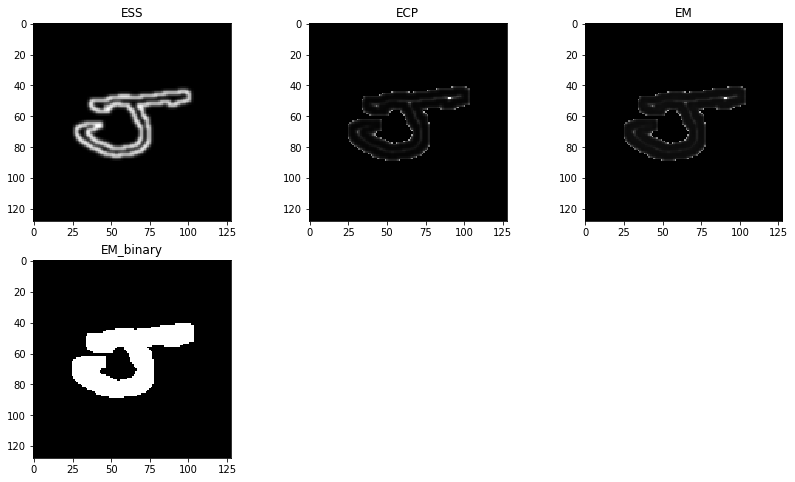

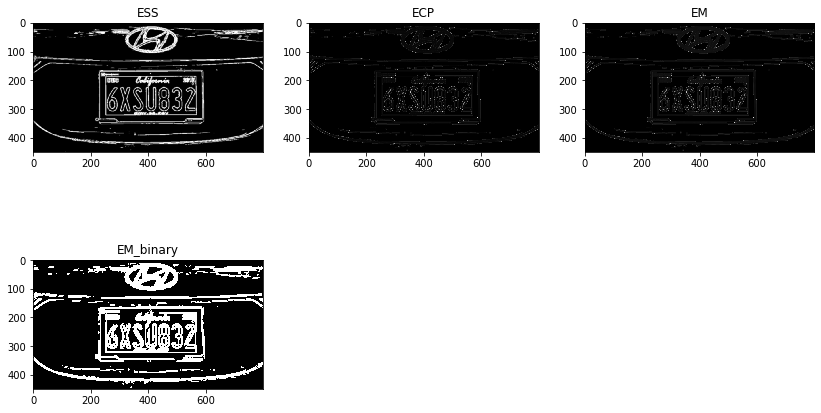

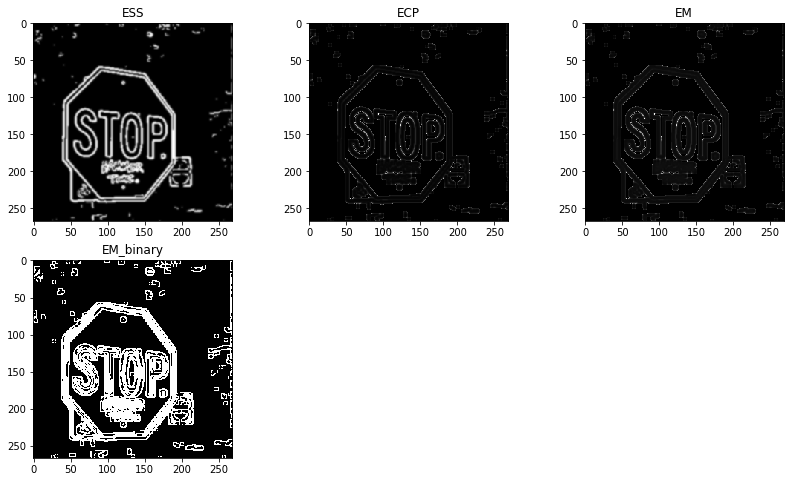

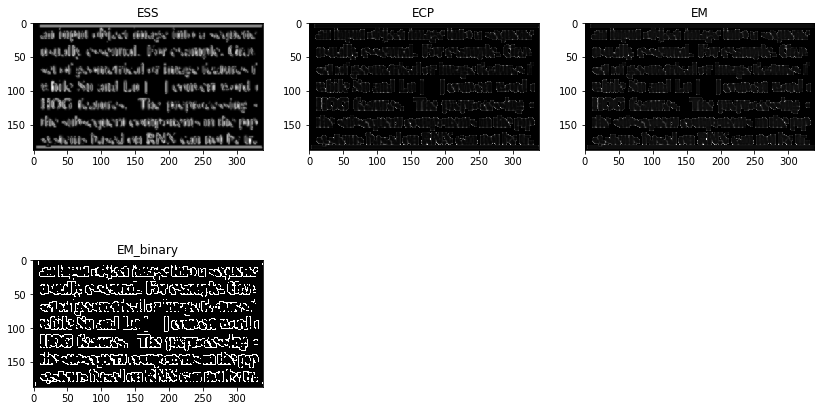

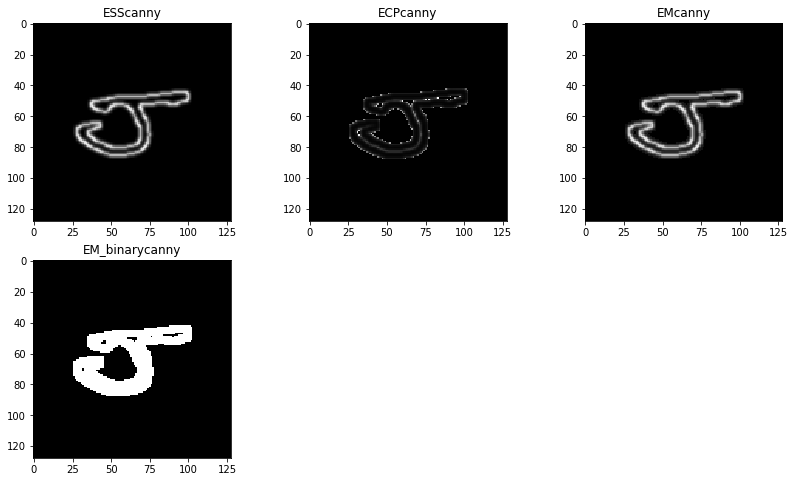

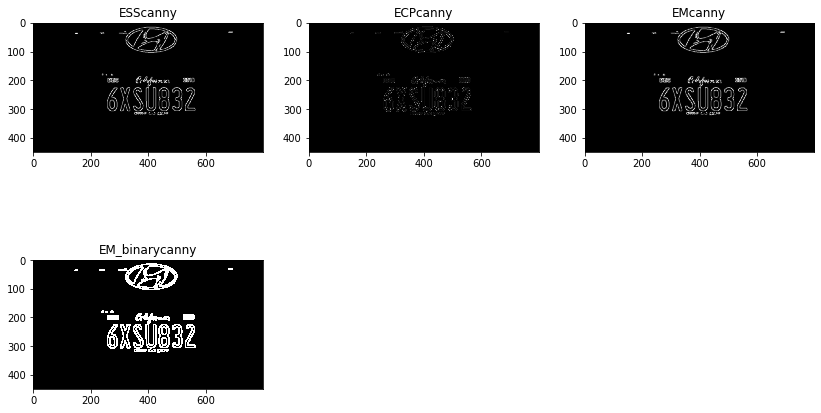

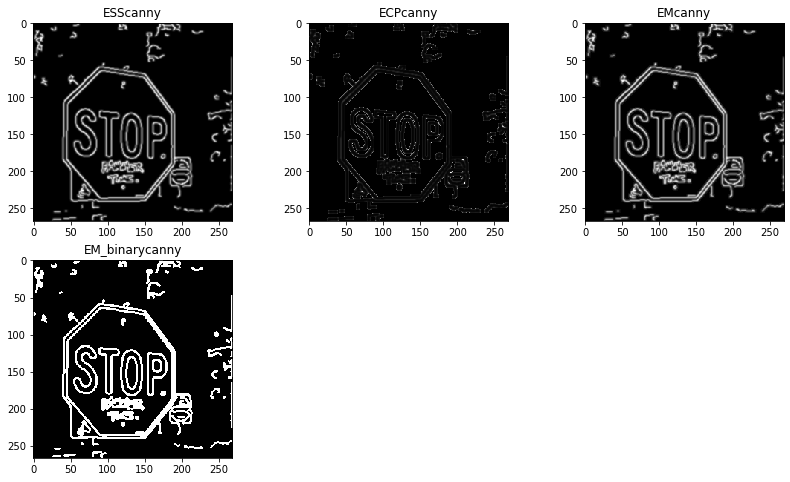

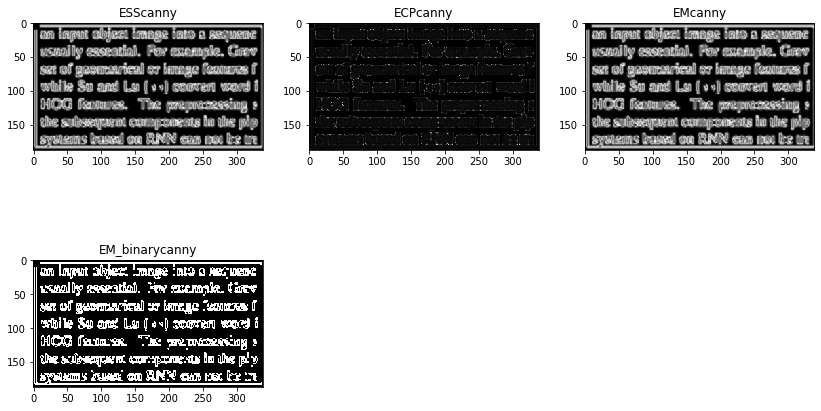

In [75]:
# Because local thresholding may have decreased the edge density, we apply ESS operator to increase the edge density
from scipy.ndimage.morphology import binary_fill_holes

def non_zero(matrix):
    return matrix[matrix > 0]

# def fill_holes(gradient_img):
#     x, y = gradient_img.shape
#     pair_coordinates = []
#     pair = 0
    
#     result = gradient_img.copy()
    
#     for i in range(x):
#         for j in range(y):
#             if gradient_img[i,j] == 0:
#                 continue
#             else:
#                 pair += 1
#                 pair_coordinates.append((i,j))
#                 if pair == 2:
#                     if j - pair_coordinates[0][1] > 20:
#                         continue
#                     result[i, pair_coordinates[0][1]:j] = 1
#                     pair = 0
#                     pair_coordinates = []
                    
#     return result

ESS_kernel = 1/220 * np.array([
    [2,4,5,4,2],
    [4,10,20,10,4],
    [5,20,40,20,5],
    [4,10,20,10,4],
    [2,4,5,4,2]
])

ECP_kernel = 1/100 * np.array([
    [8,5,4,5,8],
    [5,2,1,2,5],
    [4,1,0,1,4],
    [5,2,1,2,5],
    [8,5,4,5,8],
])


def text_area_enhancement(img, alpha = 0.5, threshold = 0.7, add_suffix = ""):
    ESS = convolve2d(img, ESS_kernel, 'same') if len(img.shape) != 3 else color_convolve(img, ESS_kernel)
    zero_points = np.argwhere(ESS == 0)
        
    ECP = convolve2d(ESS, ECP_kernel, 'same') if len(img.shape) != 3 else color_convolve(img, ESS_kernel)
    for x in zero_points:
        ECP[tuple(x)] = 0
        
    dummy = ESS.copy()
    dummy[dummy == 0] = 1
    ECP = ECP / dummy

    EM = alpha * ESS + (1-alpha) * ECP
    
    EM_threshold = EM.copy()
    EM_threshold = binarize(EM_threshold, quantile = 0.9, alpha = 0.7)
    
#     fill_holes = binary_fill_holes(img)
    
    return {
        "ESS" + add_suffix: ESS,
        "ECP" + add_suffix: ECP,
        "EM" + add_suffix: EM,
        "EM_binary"+ add_suffix: EM_threshold,
#         "fill_holes" + add_suffix: fill_holes(EM_threshold) # not working
    }

enhance_j = text_area_enhancement(edge_j["local_threshold"])
enhance_license_plate = text_area_enhancement(edge_license_plate["local_threshold"])
enhance_stop = text_area_enhancement(edge_stop["local_threshold"])
# enhance_tintin = text_area_enhancement(edge_tintin["local_threshold"])
enhance_text = text_area_enhancement(edge_text["local_threshold"])

enhance_canny_j = text_area_enhancement(edge_j["canny_local_threshold"], add_suffix="canny")
enhance_canny_license_plate = text_area_enhancement(edge_license_plate["canny_local_threshold"], add_suffix="canny")
enhance_canny_stop = text_area_enhancement(edge_stop["canny_local_threshold"], add_suffix="canny")
enhance_canny_text = text_area_enhancement(edge_text["canny_local_threshold"], add_suffix="canny")

plot_all(enhance_j)
plot_all(enhance_license_plate)
plot_all(enhance_stop)
# plot_all(enhance_tintin)
plot_all(enhance_text)

plot_all(enhance_canny_j)
plot_all(enhance_canny_license_plate)
plot_all(enhance_canny_stop)
plot_all(enhance_canny_text)



We can see that when we try to do "text area enhancement", the image becomes a loit noisier, especially the case for Sobel. As Canny had already less "edges", the noise is less prohiminent, but still there.

But why would we need to enhance the text/edges ? Isn't just the contour sufficient ?

Let's see if we can have some good bounding boxes in both cases.

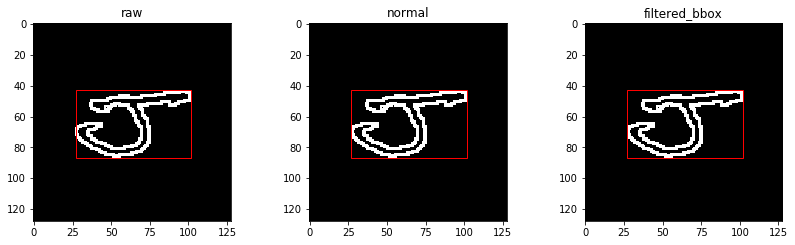

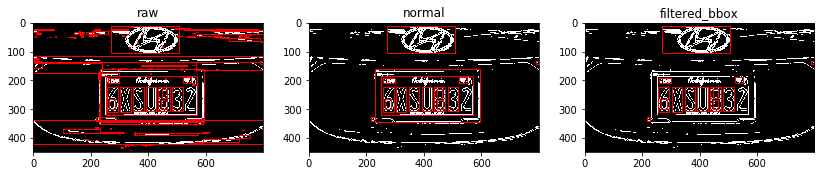

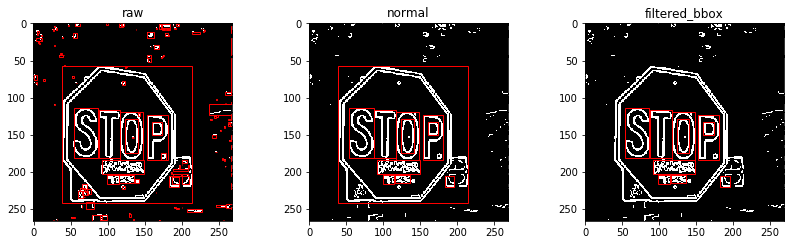

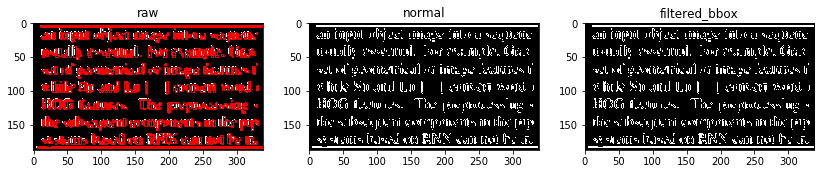

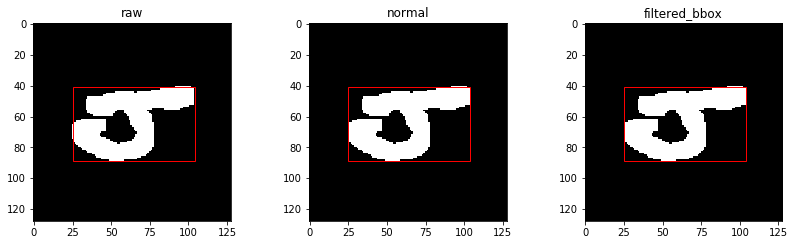

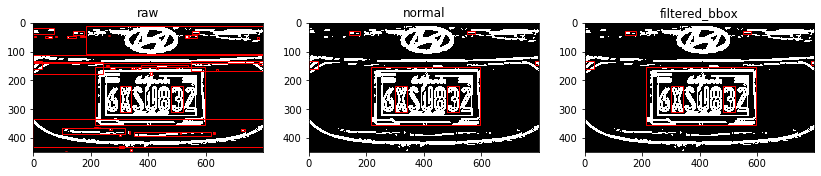

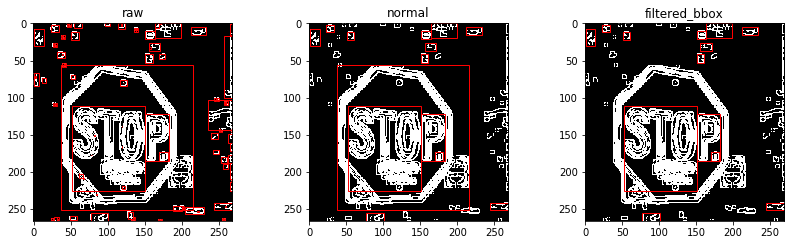

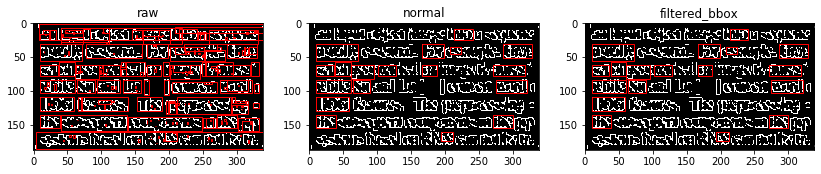

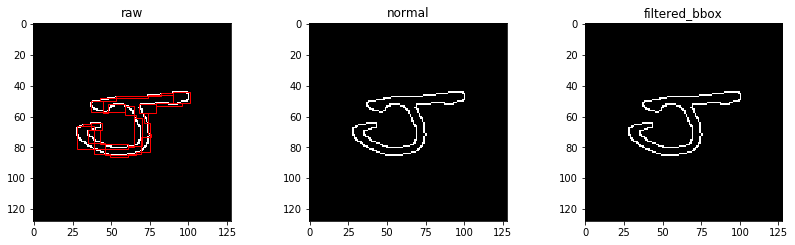

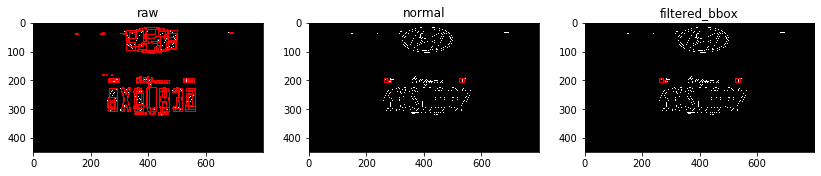

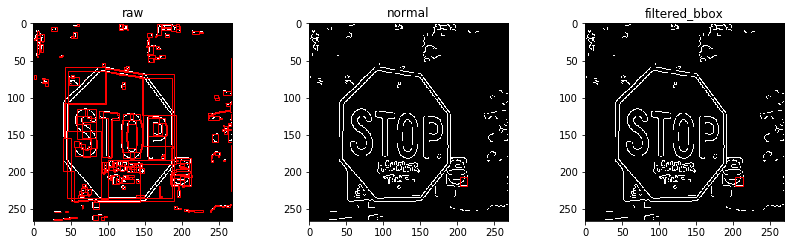

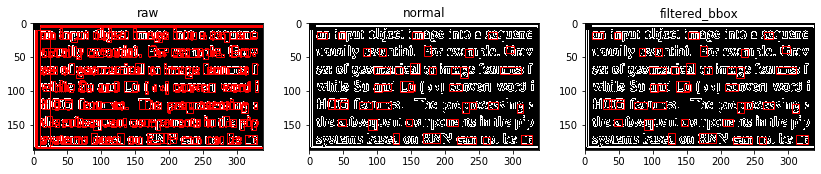

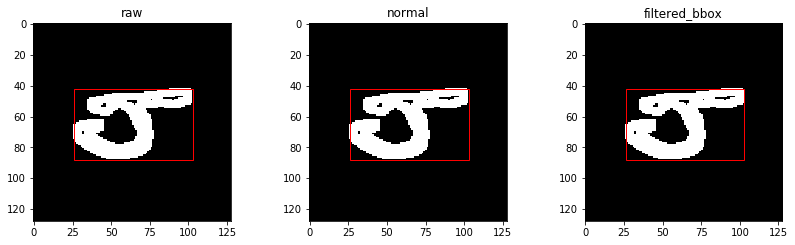

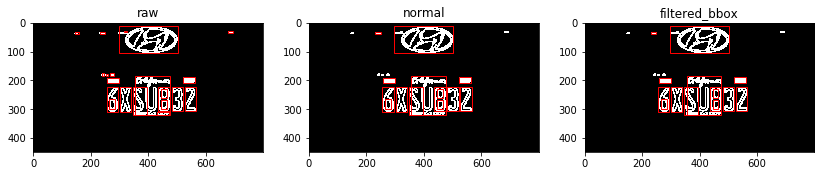

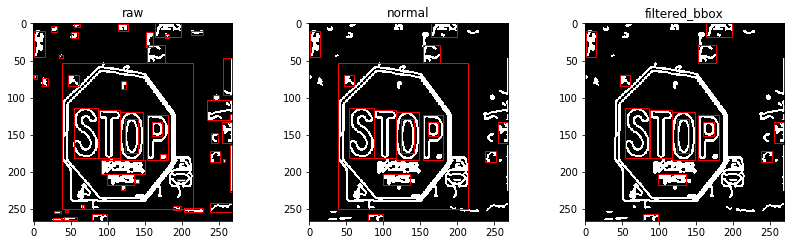

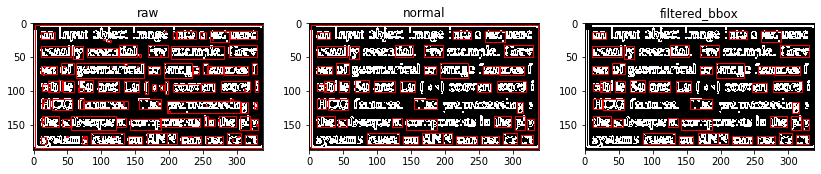

In [91]:
from scipy.ndimage import find_objects, label
import matplotlib.patches

def get_bbox(img, frame_id = 1):
    labeled_image, num_features = label(img)
    objs = find_objects(labeled_image)
    bboxes = []
    raw = []
    for i, ob in enumerate(objs):
        if len(ob) == 0:
            continue
        x = ob[0].start
        y = ob[1].start
        dx = int(ob[0].stop - ob[0].start)
        dy = int(ob[1].stop - ob[1].start)
        bbox = [frame_id, i, x, y, dx, dy]
        raw.append(bbox)
        if dx < 10 or dy < 10:
            continue
        if dy > 3 * dx:
            continue
        elif not check_count_feature(img, bbox):
            continue
        bboxes.append(bbox)
    return {
        "raw": raw,
        "normal": bboxes,
        "filtered_bbox": filter_bbox(bboxes)
    }

def check_count_feature(binary_img, bbox):
    x, y ,dx, dy = bbox[2:6]
    window = binary_img[x:x+dx,y:y+dy]
    window = binary_fill_holes(window)
    return np.sum(window) / (dx * dy) > 0.3

def filter_bbox(bboxes): # bboxes = [[frame_id, id, x, y ,dx, dy]]
    if len(bboxes) == 0:
        return bboxes
    array = np.array(bboxes)
    #sort bboxes via x
    array = array[array[:, 2].argsort()]
    
    bbox_to_remove = []
    
    for i in range(len(bboxes)):
        current_bb = array[i,:]
        
        count_bbox_inside = 0
        for bbox in array[i + 1:,:]:
            x,y,dx,dy = bbox[2:6]
            if x+dx < current_bb[2] + current_bb[4] and y > current_bb[3] and y+dy < current_bb[3] + current_bb[5]:
                count_bbox_inside += 1
            if count_bbox_inside > 2:
                bbox_to_remove.append(i)
    
    bbox_accepted = []
    for i in range(len(array)):
        if i not in bbox_to_remove:
            bbox_accepted.append(list(array[i]))
    return bbox_accepted

def draw_rectangle(img, dict_bboxes):
    n_bboxes = len(dict_bboxes.keys())
    plt.figure(figsize=(14,8))
    for i, key in enumerate(dict_bboxes):
        subplot_tag = get_subplot_tag(n_bboxes, max_y=3) + str(i + 1)
        plt.subplot(subplot_tag)
        if GREY:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(img)
        plt.title(key)
        bboxes = dict_bboxes[key]
        for bb in bboxes:
            x, y = bb[2:4]
            dx, dy = bb[4:6]

            rect = matplotlib.patches.Rectangle(
                (y, x), dy, dx, linewidth=1, edgecolor="r", facecolor="none"
            )
            plt.gca().add_patch(rect)
    plt.show()

draw_rectangle(edge_j["local_threshold"], get_bbox(edge_j["local_threshold"], 1))
draw_rectangle(edge_license_plate["local_threshold"], get_bbox(edge_license_plate["local_threshold"], 1))
draw_rectangle(edge_stop["local_threshold"], get_bbox(edge_stop["local_threshold"], 1))
# draw_rectangle(edge_tintin["local_threshold"], get_bbox(edge_tintin["local_threshold"], 1))
draw_rectangle(edge_text["local_threshold"], get_bbox(edge_text["local_threshold"], 1))

draw_rectangle(enhance_j["EM_binary"], get_bbox(enhance_j["EM_binary"], 1))
draw_rectangle(enhance_license_plate["EM_binary"], get_bbox(enhance_license_plate["EM_binary"], 1))
draw_rectangle(enhance_stop["EM_binary"], get_bbox(enhance_stop["EM_binary"], 1))
# draw_rectangle(enhance_tintin["EM_binary"], get_bbox(enhance_tintin["EM_binary"], 1))
draw_rectangle(enhance_text["EM_binary"], get_bbox(enhance_text["EM_binary"], 1))

draw_rectangle(edge_j["canny_local_threshold"], get_bbox(edge_j["canny_local_threshold"], 1))
draw_rectangle(edge_license_plate["canny_local_threshold"], get_bbox(edge_license_plate["canny_local_threshold"], 1))
draw_rectangle(edge_stop["canny_local_threshold"], get_bbox(edge_stop["canny_local_threshold"], 1))
# draw_rectangle(edge_tintin["canny"], get_bbox(edge_tintin["canny"], 1))
draw_rectangle(edge_text["canny_local_threshold"], get_bbox(edge_text["canny_local_threshold"], 1))

draw_rectangle(enhance_canny_j["EM_binarycanny"], get_bbox(enhance_canny_j["EM_binarycanny"], 1))
draw_rectangle(enhance_canny_license_plate["EM_binarycanny"], get_bbox(enhance_canny_license_plate["EM_binarycanny"], 1))
draw_rectangle(enhance_canny_stop["EM_binarycanny"], get_bbox(enhance_canny_stop["EM_binarycanny"], 1))
draw_rectangle(enhance_canny_text["EM_binarycanny"], get_bbox(enhance_canny_text["EM_binarycanny"], 1))


<b>Bounding box selection</b>
- height and width > 10 pixels
- width / height ratio not bigger than 3
- For each bounding box, if you binary fill the imagine in it, check that ratio of 1 is bigger than 0.3

<b>Sobel:</b> We can see that even with just the contour, we can detect well the letters. It's actually worse on the "text area enhancement" image. It might be because it becomes too noisy
- first, we detect a lot more noisy images
- second, we detect "words" or "chunk of letters", because the letters become attached. It could actually be used to detect words rather than letters.

<b>Canny:</b> For the contour, we actually do not detect well at all. We detect several small bounding boxes, but never the letter in whole. It might be because Canny has less "edges", so somehow, openCV detects several objects in it. However, after "text area enhancement", it becomes way better. As the image is not too noisy, it is less likely to have "chunk of words". However, we still have some noises bounding boxes.

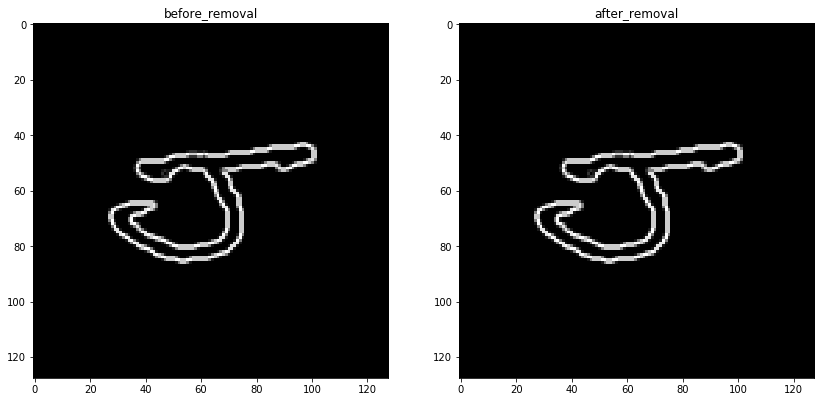

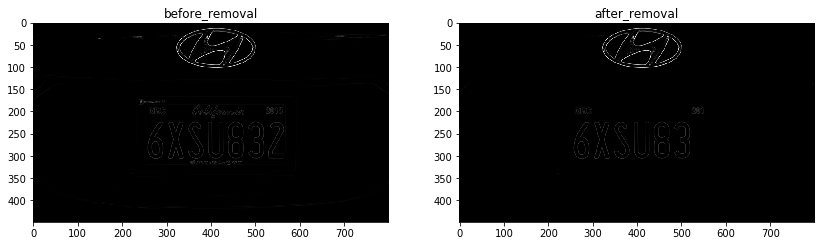

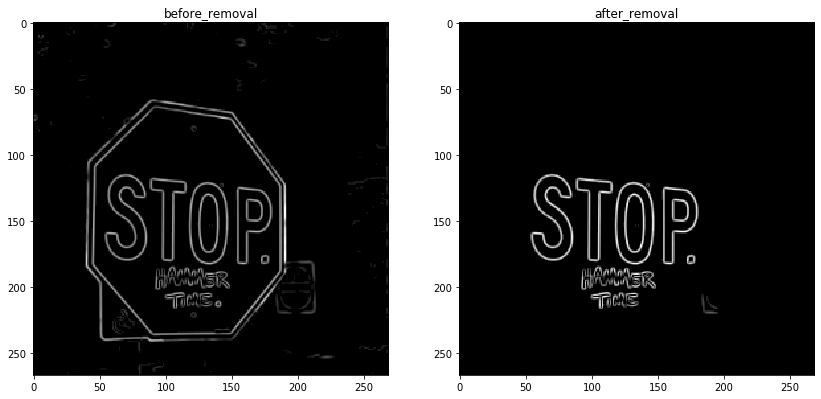

In [20]:
j_bbox = get_bbox(edge_j["local_threshold"], 1)["filtered_bbox"]
license_plate_bbox = get_bbox(edge_license_plate["local_threshold"], 1)["filtered_bbox"]
stop_bbox = get_bbox(edge_stop["local_threshold"], 1)["filtered_bbox"]

def remove_not_bbox(img, bboxes):
    result = np.zeros(img.shape)
    for bbox in bboxes:
        x,y,dx,dy = bbox[2:6]
        result[x:x+dx,y:y+dy] = img[x:x+dx,y:y+dy]
    return {
        "before_removal": img,
        "after_removal": result
    }

perfect_j = remove_not_bbox(edge_j["local_threshold"], j_bbox)
perfect_license_plate = remove_not_bbox(edge_license_plate["local_threshold"], license_plate_bbox)
perfect_stop = remove_not_bbox(edge_stop["local_threshold"], stop_bbox)

plot_all(perfect_j)
plot_all(perfect_license_plate)
plot_all(perfect_stop)


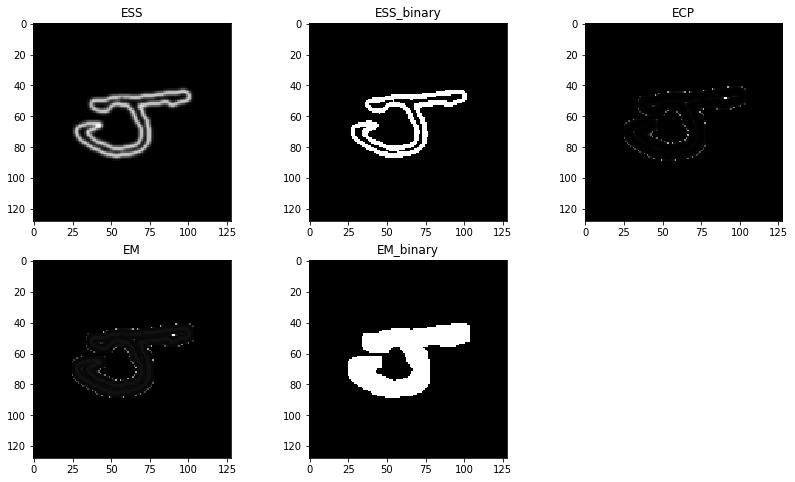

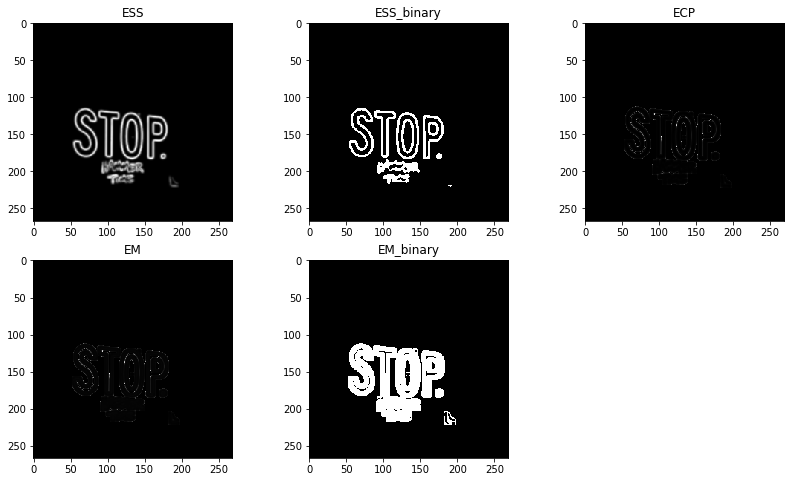

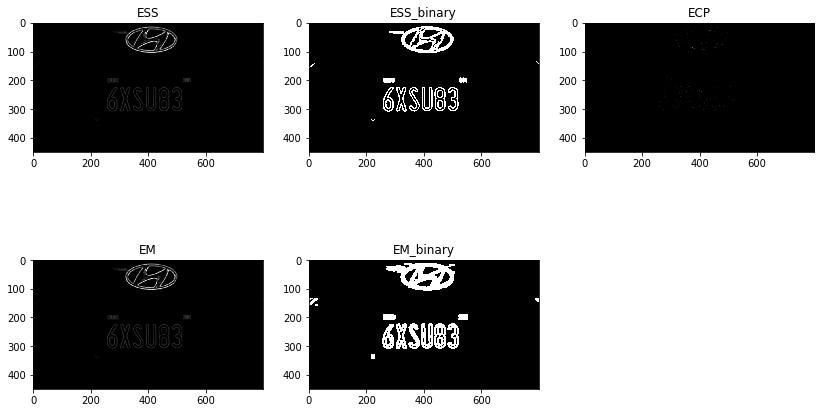

In [21]:
enhance_perfect_j = text_area_enhancement(perfect_j["after_removal"])
enhance_perfect_license_plate = text_area_enhancement(perfect_stop["after_removal"])
enhance_perfect_stop = text_area_enhancement(perfect_license_plate["after_removal"])

plot_all(enhance_perfect_j)
plot_all(enhance_perfect_license_plate)
plot_all(enhance_perfect_stop)

# plt.imshow(binary_fill_holes(perfect_stop["after_removal"]))

In [92]:
# def density_stroke_map(img, height = 10, width = 10):
#     H = height
#     W = width
#     kernel = np.zeros((H,W)) + 1
    
#     DSM = 1/(H * W) * convolve2d(img, kernel, 'same')
    
#     DSM = binarize(DSM, quantile = 0.9, alpha = 0.9)
# #     N = img.shape[0] * img.shape[1]
# #     k = 0.35
# #     threshold = k * ((1/N)*np.sum(DSM) - 30) + 30
    
# #     DSM[DSM < threshold] = 0
# #     DSM[DSM > 0] = 1
#     return DSM


# DSM_j = density_stroke_map(enhance_j["EM_binary"])
# DSM_license_plate = density_stroke_map(enhance_license_plate["EM_binary"])
# DSM_stop = density_stroke_map(enhance_stop["EM_binary"])
# # DSM_tintin = density_stroke_map(enhance_tintin["EM_binary"])
# DSM_text = density_stroke_map(enhance_text["EM_binary"])

# plot_all({
#     "DSM_j": DSM_j,
#     "DSM_license_plate": DSM_license_plate,
#     "DSM_stop": DSM_stop,
# #     "DSM_tintin": DSM_tintin,
#     "DSM_text": DSM_text,
# })


[]


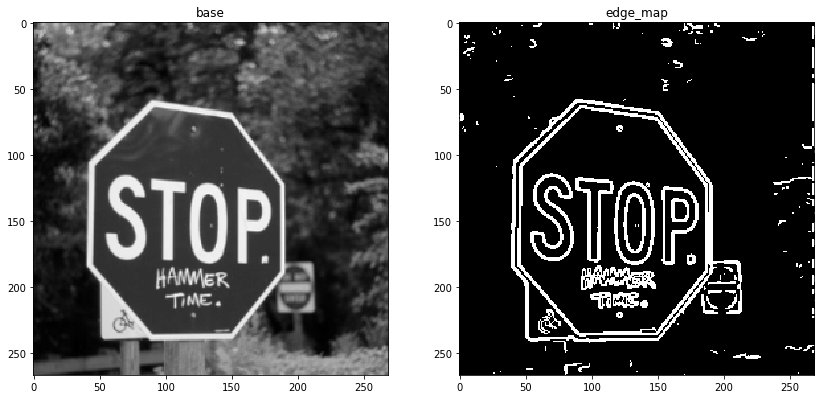

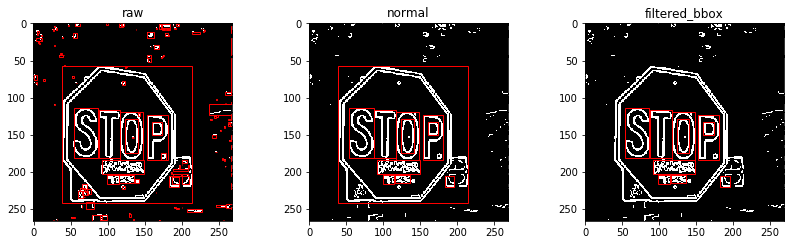

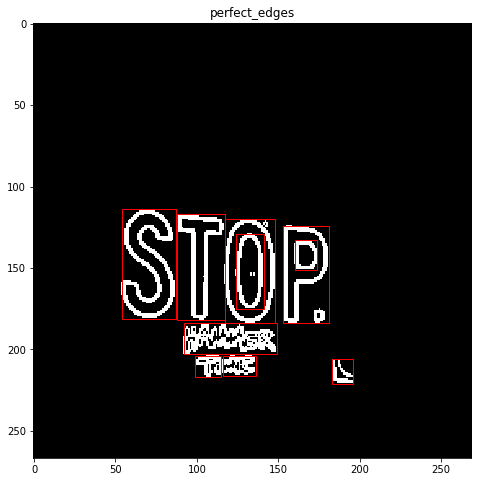

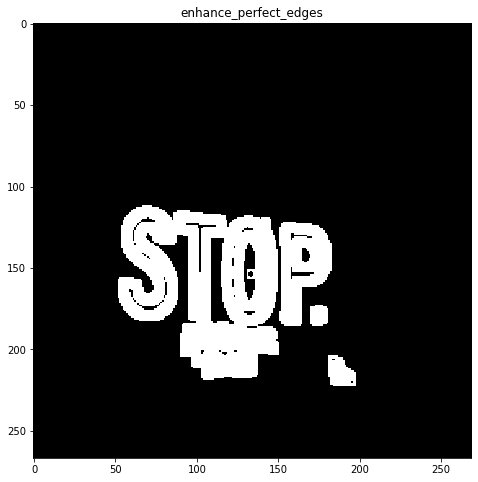

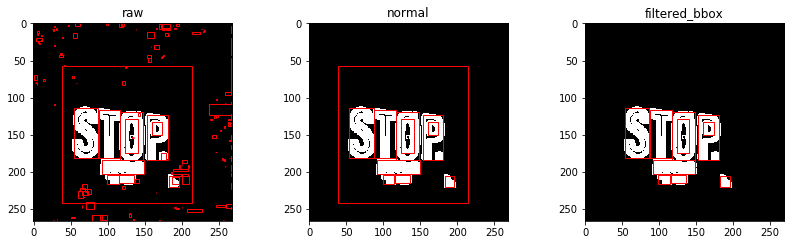

In [87]:
#pipeline

def find_text(img):
#     denoised = median_filter(img, size=(5,5))
#     denoised = gaussian_filter(img, sigma=3)
#     edge_map = edge_detection(denoised)["local_threshold"]
    edge_map = edge_detection(img, True)["local_threshold"]
    print(edge_map[edge_map > 1])
    list_bboxes = get_bbox(edge_map)
    perfect_edges = remove_not_bbox(edge_map, list_bboxes["filtered_bbox"])["after_removal"]
    enhance_perfect_edges = text_area_enhancement(perfect_edges)["EM_binary"]

    plot_all({
        "base": img,
        "edge_map": edge_map
    })
    draw_rectangle(edge_map, list_bboxes)
    draw_rectangle(perfect_edges, {"perfect_edges": list_bboxes["filtered_bbox"]})
    plot_all({"enhance_perfect_edges": enhance_perfect_edges})
    draw_rectangle(enhance_perfect_edges, list_bboxes)
    
# find_text(read("kanji.png"))
# find_text(read("handwritten.png"))
# find_text(read("license_plate.jpg"))
find_text(read("stop.png"))